In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fremtpl-french-motor-tpl-insurance-claims/freMTPLfreq.csv
/kaggle/input/fremtpl-french-motor-tpl-insurance-claims/freMTPLsev.csv


In [2]:
import pandas as pd

# Load frequency and severity datasets
freq = pd.read_csv("/kaggle/input/fremtpl-french-motor-tpl-insurance-claims/freMTPLfreq.csv")
sev = pd.read_csv("/kaggle/input/fremtpl-french-motor-tpl-insurance-claims/freMTPLsev.csv")

# Quick peek
print(freq.head())
print(sev.head())


   PolicyID  ClaimNb  Exposure Power  CarAge  DriverAge  \
0         1        0      0.09     g       0         46   
1         2        0      0.84     g       0         46   
2         3        0      0.52     f       2         38   
3         4        0      0.45     f       2         38   
4         5        0      0.15     g       0         41   

                                Brand      Gas              Region  Density  
0  Japanese (except Nissan) or Korean   Diesel           Aquitaine       76  
1  Japanese (except Nissan) or Korean   Diesel           Aquitaine       76  
2  Japanese (except Nissan) or Korean  Regular  Nord-Pas-de-Calais     3003  
3  Japanese (except Nissan) or Korean  Regular  Nord-Pas-de-Calais     3003  
4  Japanese (except Nissan) or Korean   Diesel    Pays-de-la-Loire       60  
   PolicyID  ClaimAmount
0     63987         1172
1    310037         1905
2    314463         1150
3    318713         1220
4    309380        55077


In [3]:
#Exposure sanity check/reality check
print(freq['Exposure'].describe())
# Remove policies with Exposure <= 0
freq = freq[freq['Exposure'] > 0]



count    413169.000000
mean          0.561088
std           0.369477
min           0.002732
25%           0.200000
50%           0.540000
75%           1.000000
max           1.990000
Name: Exposure, dtype: float64


In [4]:
# Claim count sanity check
print(freq['ClaimNb'].describe())
zero_claim_pct = (freq['ClaimNb'] == 0).mean() * 100
print(f"Zero claims: {zero_claim_pct:.2f}%")


count    413169.000000
mean          0.039163
std           0.204053
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           4.000000
Name: ClaimNb, dtype: float64
Zero claims: 96.28%


In [5]:
# Aggregate ClaimAmount per policy if multiple claims exist
sev_agg = sev.groupby('PolicyID')['ClaimAmount'].sum().reset_index()

# Merge with frequency table
data = freq.merge(sev_agg, on='PolicyID', how='left')
data['ClaimAmount'] = data['ClaimAmount'].fillna(0)


In [6]:
# Pure premium per policy
data['PurePremium'] = data['ClaimAmount'] / data['Exposure']

# Check distribution
print(data['PurePremium'].describe())


count    4.131690e+05
mean     3.711403e+02
std      3.493029e+04
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.824670e+07
Name: PurePremium, dtype: float64


In [7]:
#Exploratory Actuarial Analysis
#Goal: See how claim frequency varies by risk factors.
import pandas as pd

# Compute frequency per policy
data['Frequency'] = data['ClaimNb'] / data['Exposure']

# Example: average frequency by Power
freq_by_power = data.groupby('Power')['Frequency'].mean()
print(freq_by_power)


Power
d    0.129730
e    0.121659
f    0.129320
g    0.104247
h    0.102775
i    0.127089
j    0.110421
k    0.098891
l    0.147939
m    0.080151
n    0.086828
o    0.090353
Name: Frequency, dtype: float64


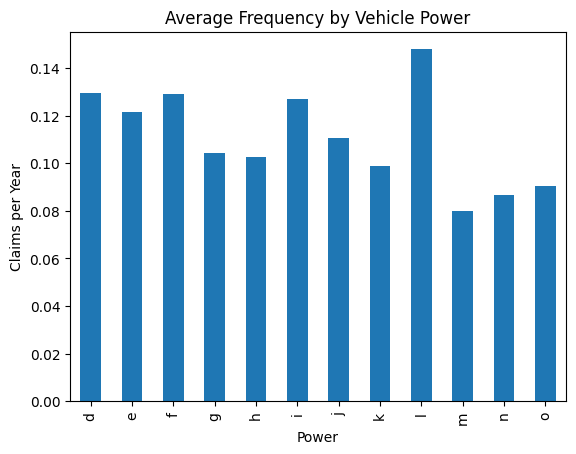

In [8]:
#Plot frequency by risk factor
import matplotlib.pyplot as plt

freq_by_power.plot(kind='bar', title='Average Frequency by Vehicle Power')
plt.ylabel('Claims per Year')
plt.show()


In [9]:
#Severity Analysis
#See how claim size varies by risk factors.
#Severity = average claim amount per claim: i.e.,Severity = ClaimAmount/ClaimNb(only for ClaimNb>0)

# Only policies with claims
sev_data = data[data['ClaimNb'] > 0].copy()

# Compute per-claim severity
sev_data['Severity'] = sev_data['ClaimAmount'] / sev_data['ClaimNb']

# Average severity by Power
sev_by_power = sev_data.groupby('Power')['Severity'].mean()
print(sev_by_power)

Power
d    1852.366209
e    1766.834871
f    2227.403138
g    2028.024816
h    1702.537719
i    4668.267341
j    1913.197329
k    1858.929293
l    1773.402597
m    2704.801370
n    1822.875000
o    1314.607843
Name: Severity, dtype: float64


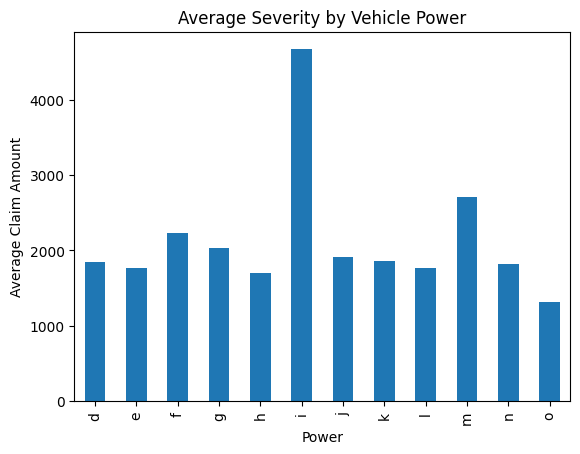

In [10]:
# plot Severity
sev_by_power.plot(kind='bar', title='Average Severity by Vehicle Power')
plt.ylabel('Average Claim Amount')
plt.show()


Power
d    300.945566
e    321.914432
f    596.183368
g    242.219881
h    253.528463
i    771.806090
j    212.021552
k    259.902691
l    274.204325
m    178.829450
n    334.184591
o    138.787584
Name: PurePremium, dtype: float64


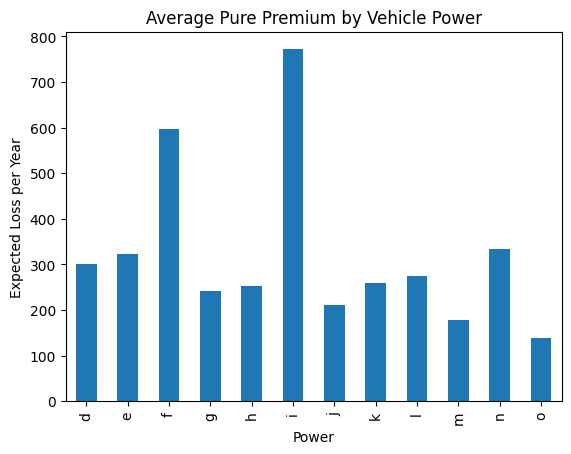

In [11]:
#Pure Premium Analysis
#Goal: Combine frequency & severity to see expected loss per exposure.
#Pure Premium = Frequency × Severity = ClaimAmount/Exposure


# Average pure premium by risk factor
pp_by_power = data.groupby('Power')['PurePremium'].mean()
print(pp_by_power)

# Plot
pp_by_power.plot(kind='bar', title='Average Pure Premium by Vehicle Power')
plt.ylabel('Expected Loss per Year')
plt.show()


/tmp/ipykernel_55/963617100.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  freq_by_age = data.groupby('DriverAgeGroup')['Frequency'].mean()


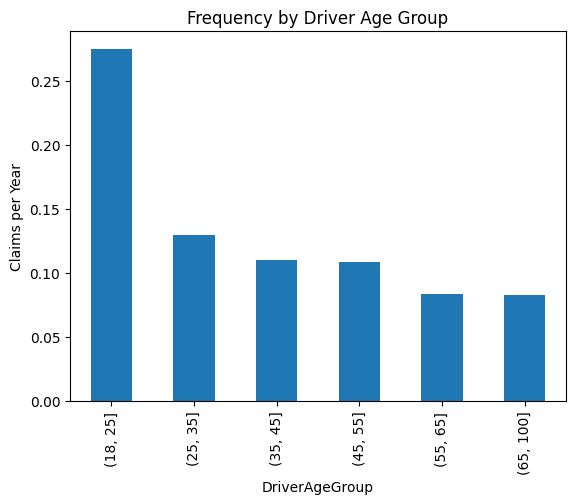

In [12]:
#Exploratory checks for other risk factors

# Example: Frequency by DriverAge group
data['DriverAgeGroup'] = pd.cut(data['DriverAge'], bins=[18,25,35,45,55,65,100])
freq_by_age = data.groupby('DriverAgeGroup')['Frequency'].mean()
freq_by_age.plot(kind='bar', title='Frequency by Driver Age Group')
plt.ylabel('Claims per Year')
plt.show()


In [13]:
#GLM Modeling for Actuarial Pricing
#In insurance, we often model frequency and severity separately, then combine them into pure premium, or use a Tweedie GLM to model pure premium directly.
#Frequency GLM
#Goal: Model number of claims per policy as a function of risk factors.


In [14]:
#Frequency GLM
#Goal: Model number of claims per policy as a function of risk factors.


import statsmodels.api as sm
import statsmodels.formula.api as smf

# Frequency GLM formula
formula_freq = 'ClaimNb ~ C(Power) + CarAge + DriverAge + C(Region)'

# Poisson GLM with exposure as offset
freq_glm = smf.glm(formula=formula_freq,
                   data=data,
                   family=sm.families.Poisson(),
                   offset=np.log(data['Exposure'])).fit()

print(freq_glm.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                ClaimNb   No. Observations:               413169
Model:                            GLM   Df Residuals:                   413146
Model Family:                 Poisson   Df Model:                           22
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -68095.
Date:                Sun, 08 Feb 2026   Deviance:                   1.0493e+05
Time:                        17:56:12   Pearson chi2:                 7.18e+05
No. Iterations:                     7   Pseudo R-squ. (CS):           0.001645
Covariance Type:            nonrobust                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

In [15]:
#Severity GLM
#Goal: Model cost per claim.

# Only policies with claims
sev_data = data[data['ClaimNb'] > 0].copy()
sev_data['Severity'] = sev_data['ClaimAmount'] / sev_data['ClaimNb']

# Gamma GLM with log link
formula_sev = 'Severity ~ C(Power) + CarAge + DriverAge + C(Region)'
sev_glm = smf.glm(formula=formula_sev,
                  data=sev_data,
                  family=sm.families.Gamma(link=sm.families.links.log())).fit()

print(sev_glm.summary())


/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


                 Generalized Linear Model Regression Results                  
Dep. Variable:               Severity   No. Observations:                15390
Model:                            GLM   Df Residuals:                    15367
Model Family:                   Gamma   Df Model:                           22
Link Function:                    log   Scale:                          27.549
Method:                          IRLS   Log-Likelihood:            -1.5877e+05
Date:                Sun, 08 Feb 2026   Deviance:                       23575.
Time:                        18:02:40   Pearson chi2:                 4.23e+05
No. Iterations:                    30   Pseudo R-squ. (CS):           0.003051
Covariance Type:            nonrobust                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

In [16]:
#Combine Frequency × Severity → Pure Premium

#Once we have frequency GLM and severity GLM, we compute expected loss (pure premium):

#Pure Premium=E[ClaimNb]×E[Severity]
#Pure Premium=E[ClaimNb]×E[Severity]

# Predict frequency per policy
data['PredFreq'] = freq_glm.predict(data, offset=np.log(data['Exposure']))

# Predict severity per policy (0 for policies with no claims)
data['PredSev'] = sev_glm.predict(data)

# Compute predicted pure premium
data['PredPurePremium'] = data['PredFreq'] * data['PredSev']

# Quick check
print(data[['PolicyID', 'PredPurePremium']].head())


   PolicyID  PredPurePremium
0         1        12.614784
1         2       117.737985
2         3        95.171962
3         4        82.360352
4         5        20.618392
